<h2><center>Unsupervised sound embedding (review)</center></h2>
    There are 3 different approaches for sound embedding:
<ol>
  <li>Represent sound as a sentence and use word embedding system like word2vec. </li>
  <li>Represent sound as aspectrogram and use CNN</li>
  <li>Represent sound as a spectrogram and use RNN (auDeep)</li>
</ol>

<h3>Word2vec</h3>

   In the word2vec embedding, sound slices are used as words. Each slices is a short snippet of the sound. Based on the idea that snippets appearing in the similar order tend to have similar sound type, the standard word2vec algorithm can be applied to the data.

<h3>Spectrogram</h3>

   There are different types sound encoding in frequency domain: chromagram, tempogram, mel-spectrogram, MFCC. etc. Spectrograms are essentially 2-D time-frequency plots typically used to visualize harmonic structure in audio. Mel-spectrograms are compressed version of spectrograms which are computationally faster to process. Mel-spectrograms are mostly used in the research papers. However, different types of sound representation in the frequency domain can be combined to represent different acoustic information of the sound.

<img src="hyper_image.png" alt="" title="Hyper_image" width = "50%"/>

<h3>Convolutional Neural Network</h3>

   Mostly researchers use CNN to create sound embedding matrix. Firstly, spectogram is computed from the sound and then proceed as an image. After the image is processed it is used as an input to convolutional neural network. The simplest structure of the Deep Neural Network is presented below. It consists of several convolutional layers combined with max pooling layers and several fully connected layers in the end. The size of the last fully-connected layer is the size of the embedding space.
   
   A neural network consists of twin networks that share weights and configuration. This architecture can be extended to use both positive and negative examples at one optimization step. It is set up to take three sample: anchor item (initial sound), positive item (sound similar to initial) and negative item (sound different to the initial). This model is often called triplet networks and has been successfully applied to music metric learning when the relative similarity scores of song triplets are available.

<img src="triplet.png" alt="" title="Triplet network" width = "30%"/>

<h3>Recurrent Neural Network</h3>

   Also, it is possible to consider spectogram as a sequence. Spectrograms are extracted from the sound file and then spectrograms are proceed through sequence-to-sequence autoencoder to compute feature vector. Besides, it is possible to combine recurrent layers with convolutional layers to achieve better results.

<img src="auDeep.png" alt="" title="auDeep" width = "50%"/>
<img src="results.png" alt="" title="auDeep" width = "50%"/>

<h3>Loss function</h3>

   Typically, triplet loss is used as a loss function in embedding tasks. It is based on 3 different outputs from the Neural Network: anchor $f_i^a$, positive $f_i^p$ and negative $f_i^n$. Any distance measurement function, e.g. cosine, l2 loss, euclidian, etc. can be used as a distance metric between anchor and examples
   
   Positive sample is generated using sound augmentation for unsupervised tasks. There are several augmentation technique that can be applied to the sample: select another part of the sound not similar to the anchor, add noise, shift pitch, dilate or compress time. For negative example, usually, a different sound is selected.

\begin{equation*}
Loss = \sum_{i=1}^N \left[||f_i^a - f_i^p||_2^2 - ||f_i^a - f_i^n||_2^2 + \alpha \right]
\end{equation*}

<h2><center>Unsupervised sound embedding (algorithm)</center></h2>
I have selected algorithm with mel-spectogram and CNN for testing. Mel-spectrogram is a transform from the frequncy scale based on the fact that human can easily detect difference between 100 Hz and 200 Hz sound, but difference between 1100 Hz and 1200 Hz not so good. So, it is required to transform sound from frequency scale to Mel Scale to compencate this effect.
All sound were cutted to 5 sec long. Selecting another part of the sound, adding noise and pith shifting were used as a data augmentation techniques for positive sample.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import librosa.display
from os import listdir
from os.path import join
import IPython.display as ipd

from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [4]:
#Define parameters
AUDIO_LENGTH = 5
n_fft = 2048
hop_length = 512
n_mels = 128 
samplerate = 44100

In [5]:
def gen_melspectrogram(sound, sr = 44100):
    S = librosa.feature.melspectrogram(sound, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

In [41]:
def plot_melspectrogram(S, sr = 44100):
    hop_length = 512
    librosa.display.specshow(S, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')

In [42]:
"""
Define functions for sound aumentation
"""

#Add gaussian noise to the sound
def additive_noise(anchor):
    amt = np.random.uniform(0.02, 0.05)
    return anchor + np.random.normal(0, amt, anchor.shape).astype(anchor.dtype)

#Shift the pitch of the sound
def pitch(anchor, sr = 44100):
    n_steps =  np.random.uniform(-3, 3)
    pitched = librosa.effects.pitch_shift(anchor, sr, n_steps)
    return pitched


In [43]:
# function for generating random positive sample
def random_positive(file):
    start_second = np.random.rand() * 4.0 + 5.0
    positive_sound = file[int(samplerate * start_second):int(samplerate * (AUDIO_LENGTH + start_second)), 1].astype(float)
    positive_sound = additive_noise(positive_sound)
    positive_sound = pitch(positive_sound)
    positive_spectr = gen_melspectrogram(positive_sound)
    return positive_spectr

# function for generating random negative sample
def random_negative(paths):
    file = paths[np.random.randint(0, len(paths) - 1)]
    start_second = np.random.rand() * 10.0
    negative_sound = file[int(samplerate * start_second):int(samplerate * (AUDIO_LENGTH + start_second)), 1].astype(float)
    negative_spectr = gen_melspectrogram(negative_sound)
    return negative_spectr

In [58]:
#search for all files in the data directory
datafolder = 'data/'
paths = []
folders = [1,2]
for i in folders:
    files = [join(datafolder + str(i), f) for f in listdir(datafolder + str(i))]
    paths.append(files)

In [59]:
#function for reading sound files
def read_data(paths):
    sound_files = []
    for counter, path in enumerate(paths):
        files = []
        for file in path:
            samplerate, data = wavfile.read(file)
            files.append(data)
        sound_files.append(files)
    return sound_files

In [60]:
sound_files = read_data(paths)
ipd.Audio(sound_files[0][0][:,1], rate=samplerate)

In [61]:
def generate_triplet(sound_files):
    anchor_train = []
    positive_train = []
    negative_train = []
    anchor_test = [] 
    positive_test = []
    negative_test = []
    y_train = []
    y_test = []
    n_triplets = 10
    for counter, sounds in enumerate(sound_files):
        print(counter)
        arr = np.delete(range(0, len(sound_files)), counter)
        for xcounter, file in enumerate(sounds):
            for i in range(0, n_triplets):
                start_second = np.random.rand() * 5.0
                anchor_sound = file[int(samplerate * start_second):int(samplerate * (AUDIO_LENGTH + start_second)), 1].astype(float)
                anchor_spectr = gen_melspectrogram(anchor_sound)

                positive = random_positive(file)            
                negative = random_negative(sound_files[np.random.choice(arr)])
                if(np.random.rand() < 0.75):
                    anchor_train.append(anchor_spectr)
                    positive_train.append(positive)
                    negative_train.append(negative)
                    y_train.append(counter)
                else:
                    anchor_test.append(anchor_spectr)
                    positive_test.append(positive)
                    negative_test.append(negative)
                    y_test.append(counter)
    return [anchor_train, positive_train, negative_train, y_train, anchor_test, positive_test, negative_test, y_test]

In [62]:
anchor_train, positive_train, negative_train, y_train, anchor_test, positive_test, negative_test, y_test = generate_triplet(sound_files)

0
1


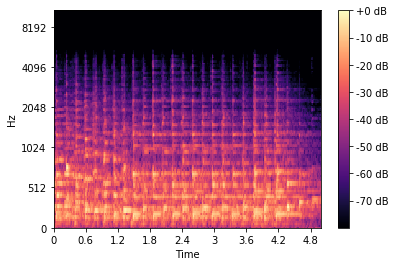

In [63]:
plot_melspectrogram(anchor_train[np.random.randint(0, len(anchor_train))])

In [64]:
#Reshape and normalize data
anchor_train = np.array(anchor_train).reshape(-1,128, 431, 1)
positive_train = np.array(positive_train).reshape(-1,128, 431, 1)
negative_train = np.array(negative_train).reshape(-1,128, 431, 1)
anchor_test = np.array(anchor_test).reshape(-1,128, 431, 1)
positive_test = np.array(positive_test).reshape(-1,128, 431, 1)
negative_test = np.array(negative_test).reshape(-1,128, 431, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)

anchor_train = (anchor_train - np.min(anchor_train))/(np.max(anchor_train) - np.min(anchor_train))
positive_train = (positive_train - np.min(anchor_train))/(np.max(anchor_train) - np.min(anchor_train))
negative_train = (negative_train - np.min(anchor_train))/(np.max(anchor_train) - np.min(anchor_train))
anchor_test = (anchor_test - np.min(anchor_test))/(np.max(anchor_test) - np.min(anchor_test))
positive_test = (positive_test - np.min(anchor_test))/(np.max(anchor_test) - np.min(anchor_test))
negative_test = (negative_test - np.min(anchor_test))/(np.max(anchor_test) - np.min(anchor_test))

In [65]:
def triplet_loss(y_true, y_pred, alpha = 1.0):
    
    total_lenght = y_pred.shape.as_list()[-1]
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive (l2-loss)
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative (l2-loss)
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss, 0.0) # hinge loss
 
    return loss

In [66]:
#Define base network
def create_base_network(in_dims):
    model = Sequential()
    model.add(Conv2D(32, (7,7), padding='same', input_shape=(in_dims[0],in_dims[1],in_dims[2],), activation='relu', name='Conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='Pool1'))
    model.add(Conv2D(64, (5,5), padding='same', activation='relu', name='Conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='Pool2'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='Conv3'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='Pool3'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu', name='Conv4'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='Pool4'))
    
    model.add(Flatten(name='flatten'))
    model.add(Dense(200,name='Dense',activation='relu'))
    model.add(Dense(50,name='Embeddings',activation='relu'))    
    return model

In [67]:
#Define Adam optimizer with learning rate 0.001
adam_optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [68]:
anchor_input = Input((128,431,1, ), name='anchor_input')
positive_input = Input((128,431,1, ), name='positive_input')
negative_input = Input((128,431,1, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([128,431,1,])

encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)

merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)
model.summary()

W0902 08:02:25.416376  7360 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 128, 431, 1)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 128, 431, 1)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 128, 431, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           11491338    anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [ ]:
Y_train = np.empty((anchor_train.shape[0],300))
Y_test = np.empty((anchor_test.shape[0],300))
model.fit([anchor_train, positive_train, negative_train], y=Y_train, batch_size=100, epochs=9, shuffle = True, 
          validation_data=([anchor_test, positive_test, negative_test], Y_test))

W0902 08:02:29.702643  7360 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Exception ignored in: <function Wave_write.__del__ at 0x00000167B9AED598>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\wave.py", line 327, in __del__
    self.close()
  File "C:\ProgramData\Anaconda3\lib\wave.py", line 445, in close
    self._ensure_header_written(0)
  File "C:\ProgramData\Anaconda3\lib\wave.py", line 468, in _ensure_header_written
    self._write_header(datasize)
  File "C:\ProgramData\Anaconda3\lib\wave.py", line 485, in _write_header
    self._sampwidth * 8, b'data'))
struct.error: ushort format requires 0 <= number <= 0xffff


Train on 448 samples, validate on 152 samples
Epoch 1/9


<h4><center>Visualization part</center></h4>

In [1]:
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
def scatter(x, labels, subtitle=None):    
    palette = np.array(sns.color_palette("hls", 10))
    f = plt.figure(figsize=(8, 8))
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    ax.axis('off')
    ax.axis('tight')
    if subtitle != None:
        plt.suptitle(subtitle)

In [ ]:
anchor_tsne = np.reshape(anchor_train, (-1,55168))
test_tsne_embeds = tsne.fit_transform(anchor_tsne[np.array(range(0, len(anchor_tsne) - 1, 10)).astype(int)])
scatter(test_tsne_embeds, y_train[np.arange(0, len(y_train) - 1, 10)], "Samples from Training Data pure t-SNE")

In [ ]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
anchor_embbeds = trained_model.predict(anchor_train[np.arange(0, len(anchor_train) - 1, 10)])

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(anchor_embbeds )
scatter(train_tsne_embeds, y_train[np.arange(0, len(y_train) - 1, 10)], "Samples from Training Data Embedding + t-SNE")

<h4><center>Models testing</center></h4>

In [6]:
def file_to_spectr(filepath):
    samplerate, data = wavfile.read(filepath)
    start_second = np.random.randint(0, len(data)/samplerate - 5)
    sound = data[int(samplerate * start_second):int(samplerate * (AUDIO_LENGTH + start_second)), 1].astype(float)
    spectr = gen_melspectrogram(sound)
    return spectr

In [53]:
filename = 'data/5/hiphop.00010.wav'
spectr = file_to_spectr(filename)
spectr = np.array(spectr).reshape(-1,128, 431, 1)
spectr = (spectr - np.min(spectr))/(np.max(spectr) - np.min(spectr))

In [52]:
model_supervised = load_model('model.h5')
model_unsupervised = load_model('model_pure.h5')
embedded_sound = model_supervised.predict(spectr)

print(embedded_sound)

[[0.         0.         0.         0.         0.         0.00872091
  0.         0.         0.         0.         0.         0.216546
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.60269105 0.         0.5230437
  0.         1.0216191  0.08773966 0.         0.         0.
  0.         0.         0.         0.         0.3237169  0.
  0.         0.         0.         0.04174893 0.         0.
  0.15338925 0.        ]]


<h2><center>Results</center></h2>
Structure of the Neural Network is presented below. The structure is similar to AlexNet. I have used GTZAN Genre Collection
dataset converted to .wav format during the training process. I have used 70%/30% train/test split.

[GTZAN Genre Collection](http://marsyas.info/downloads/datasets.html)
<img src="model.png" alt="" title="Model" width = "20%"/>

In the end, I came up with 2 different models. 
First model has pretty descent results with t-SNE comparing to pure t-SNE. However, during the training process I have used positive sound from the same genre. So it was a supervised learning.

Second model has worse result. However, I used supervised learning in this model. I am sure that it is possible to obtain better perfomance with larger sound database and some parameter tuning.
<img src="four_class_tsne.png" alt="" title="tsne" width = "50%"/> 
<img src="four_class_model_1.png" alt="" title="tsne" width = "50%"/> 
<img src="four_class_model_2.png" alt="" title="tsne" width = "50%"/>

<h2><center>References</center></h2>

<ol>
  <li>Lee, Jongpil et al. “Deep Content-User Embedding Model for Music Recommendation.” ArXiv abs/1807.06786 (2018): n. pag.</li>
  <li>Rajat Hebbar (2017) music2vec: Generating Vector Embeddings for Genre-Classification Task, Available at: https://medium.com/@rajatheb/music2vec-generating-vector-embedding-for-genre-classification-task-411187a20820</li>
  <li>Chuan, Ching-Hua & Agres, Kat & Herremans, Dorien. (2018). From Context to Concept: Exploring Semantic Relationships in Music with Word2Vec.</li>
  <li>Xiaoyu Qi, Deshun Yang, Xiaoou Chen (2017) Audio Feature Learning with Triplet-Based Embedding Network, Available at: https://www.aaai.org/ocs/index.php/AAAI/AAAI17/paper/download/14235/14231</li>
  <li>Park, Jiyoung & Lee, Jongpil & Park, Jangyeon & Ha, Jung-Woo & Nam, Juhan. (2017). Representation Learning of Music Using Artist Labels. </li>
  <li>Jansen, Aren & Plakal, Manoj & Pandya, Ratheet & P. W. Ellis, Daniel & Hershey, Shawn & Liu, Jiayang & Channing Moore, R & A. Saurous, Rif. (2017). Unsupervised Learning of Semantic Audio Representations. </li>
  <li>Freitag, Michael & Amiriparian, Shahin & Pugachevskiy, Sergey & Cummins, Nicholas & Schuller, Björn. (2017). auDeep: Unsupervised Learning of Representations from Audio with Deep Recurrent Neural Networks. Journal of Machine Learning Research. 18. </li>
  <li>John Vinyard (2019) Audio Query-By-Example via Unsupervised Embeddings, Available at: http://johnvinyard.github.io/zounds/search/embeddings/neural-networks/pytorch/2019/02/22/unsupervised-semantic-audio-embeddings.html</li>
  <li>Xing, Zhou & Baik, Eddy & Jiao, Yan & Kulkarni, Nilesh & Li, Chris & Muralidhar, Gautam & Parandehgheibi, Marzieh & Reed, Erik & Singhal, Abhishek & Xiao, Fei & Pouliot, Chris. (2017). Modeling of the Latent Embedding of Music using Deep Neural Network.</li>
</ol>